In [1]:
# Ugly import of pygromos for now
import os, copy, glob
path = '/home/cchampion/programs/pygromos3'
cwd = os.getcwd()
os.chdir(path)
import pygromos
os.chdir(cwd)

import numpy as np
import rdkit

from pygromos.files.topology.top import Top
from pygromos.files.coord.cnf import Cnf


In [2]:
# This is the path of hybrid_topology_maker.py from which we import the code doing the work.

cwd = os.getcwd()
os.chdir('/home/cchampion/work/REEDS/input_preparation/hybrid_topologies')
from hybrid_topology_maker import constructPerturbedTopology, constructHybridConformation, \
                                  constructHybridTopology, reduceConformations, PerturbedAtom
os.chdir(cwd)

# Creation of Hybrid Topologies

In this notebook, we will write functions to create hybrid topologies from a gromos topology of multiple ligands (separate from one another) + a protein. The program will write a hybrid topology for the ligands in water as well as for the complete system. 

We will also write a function to "reduce" the conformations to match the hybrid topologies.

Finally, we will also create a ptp file for this hybrid topology 

Currently, the atoms to include as core will have to be be given when producing the input. 


In [168]:
root_dir = '/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies'

## 1: Reducing conformations for single ligand simulations

In [169]:
reduced_cnfs_path = root_dir + '/reduced_conformations'
if not os.path.exists(reduced_cnfs_path): os.mkdir(reduced_cnfs_path)

#reduceConformations(path_cnf = root_dir+'/PAK_openff_ligands.cnf', 
#                    out_path = reduced_cnfs_path)
#reduceConformations(path_cnf = root_dir+'/PAK_openff_complex.cnf', 
#                    out_path = reduced_cnfs_path, contains_protein=True)

## 2: Define Atoms to use to make the new topology

In [198]:
reduced_tops_path = root_dir + '/reduced_topologies'
core_top_path = reduced_tops_path+'/PAK_openff_ligand_1.top'
core_top = Top(core_top_path)

new_ligand_tops = []

# List of all new topologies, sorted and remove top #1 from it

reduced_tops_path = root_dir + '/reduced_topologies'
top_paths = glob.glob(reduced_tops_path + '/*ligand_*.top')

top_paths = sorted(top_paths, key = lambda x : int(x.split('_')[-1].replace(".top", "")))
top_paths.remove(core_top_path)

for p in top_paths:
    new_ligand_tops.append(Top(p))

# Write the connecting points here manually.
# In the future we can easily work from the maximum common substructure to define those.
# by iterating over bonds and finding the atom in the core_mapping list (from MCS) which has bonds
# with things which are not elements of that same list.

connecting_points = []

connecting_points.append((10, 3)) # core (lig1)

connecting_points.append((22, 25)) # lig2
connecting_points.append((22, 25)) # lig3
connecting_points.append((22, 25)) # lig4
connecting_points.append((10, 7)) # lig5
connecting_points.append((7, 18)) # lig6
connecting_points.append((10, 6)) # lig7


### 2b: Write Manually the mapping of atoms in the core

note: need to be included atoms that go up to two bonds away from the connecting core atom into the core.

In [196]:
atom_mappings = []

# init_id = ID in init_ligand's ligands topology. 
# new_ID == corresponding ID in ligand1's topology.

# Atom mappings of ligand 2 to the core.
atom_mappings.append(PerturbedAtom(atom='C15', init_lig=2, init_id=22, new_id=10)) # connecting atom. 

atom_mappings.append(PerturbedAtom(atom='C13', init_lig=2, init_id=20, new_id=14))
atom_mappings.append(PerturbedAtom(atom='C14', init_lig=2, init_id=21, new_id=15))
atom_mappings.append(PerturbedAtom(atom='C16', init_lig=2, init_id=23, new_id=11))
atom_mappings.append(PerturbedAtom(atom='C17', init_lig=2, init_id=24, new_id=12))

atom_mappings.append(PerturbedAtom(atom='H18', init_lig=2, init_id=49, new_id=41))
atom_mappings.append(PerturbedAtom(atom='H17', init_lig=2, init_id=48, new_id=43))
 
# Atom mappings of ligand 3 to the core.
atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=22, new_id=10)) # connecting atom. 

atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=20, new_id=14))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=21, new_id=15))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=23, new_id=11))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=24, new_id=12))

atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=49, new_id=41))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=3, init_id=48, new_id=43))

# Atom mappings of ligand 4 to the core.
atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=22, new_id=10)) # connecting atom. 

atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=20, new_id=14))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=21, new_id=15))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=23, new_id=11))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=24, new_id=12))

atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=51, new_id=41))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=4, init_id=50, new_id=43))

# Atom mappings of ligand 5 to the core.
atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=10, new_id=10)) # connecting atom. 

atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=11, new_id=15))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=12, new_id=14))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=14, new_id=12))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=15, new_id=11))

atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=40, new_id=41))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=5, init_id=38, new_id=43))


# Atom mappings of ligand 6 to the core.
atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=7, new_id=10)) # connecting atom. 

atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=5, new_id=15))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=6, new_id=14))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=8, new_id=12))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=9, new_id=11))

atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=37, new_id=41))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=6, init_id=36, new_id=43))

# Atom mappings of ligand 7 to the core.
atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=10, new_id=10)) # connecting atom. 

atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=11, new_id=15))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=12, new_id=14))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=14, new_id=12))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=15, new_id=11))

atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=40, new_id=41))
atom_mappings.append(PerturbedAtom(atom='x', init_lig=7, init_id=38, new_id=43))

In [199]:
# for am in atom_mappings: print (am)

constructHybridTopology(core_top, new_ligand_tops, atom_mappings, connecting_points, 
                        path_out_top=reduced_tops_path+'/PAK_openff_hybrid.top')

Working on addition of ligand 2 has: 14 atoms.
Working on addition of ligand 3 has: 12 atoms.
Working on addition of ligand 4 has: 15 atoms.
Working on addition of ligand 5 has: 13 atoms.
Working on addition of ligand 6 has: 17 atoms.
Working on addition of ligand 7 has: 13 atoms.


### 3: Append protein to the topology

In [176]:
command = "com_top @topo " + reduced_tops_path+'/PAK_openff_hybrid.top ' + reduced_tops_path+'/PAK_openff_protein.top'
command += " @param 1 @solv 1 > " + reduced_tops_path+'/PAK_openff_hybrid_complex.top'

print (command)
os.system(command)

# We can then even follow this by a red_top  to regain the nice formatting of the gromos topology
# since it is a hybrid topology, it will understand that 1:a means all ligands as they have bonds between one another.
# calling the same thing with 2:a would make a nicely formatted hybrid topology for the complex. 

command2 = "red_top @topo " + reduced_tops_path+'/PAK_openff_hybrid_complex.top @atoms 1:a' 
command2 += ' > ' + reduced_tops_path+'/PAK_openff_hybrid_ligands.top'



print (command2)
os.system(command2)



com_top @topo /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_hybrid.top /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_protein.top @param 1 @solv 1 > /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_hybrid_complex.top
red_top @topo /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_hybrid_complex.top @atoms 1:a > /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_hybrid_ligands.top


0

In [11]:
hybrid_topology_path = reduced_tops_path+'/PAK_hybrid_topology.top'

paths_input_cnfs = sorted(glob.glob(reduced_cnfs_path+'/ligand_*.cnf'))

constructHybridConformation(new_ligand_tops, connecting_points, 
                            paths_input_cnfs, path_out_cnf = reduced_cnfs_path + '/PAK_hybrid.cnf'
                           )

IndexError: list index out of range

## 4 Make a manual mapping of the core atoms of molecule 1 onto molecule 2



In [ ]:
# core_mappings = List of Tuple [(id_in_mol1, id_in_mol2)]

In [15]:
core_mappings = []

# Doing it manually between molecule 1 and molecule 2

# first benzene
core_mappings.append((10, 22))
core_mappings.append((11, 23))
core_mappings.append((12, 24))
core_mappings.append((13, 19))
core_mappings.append((14, 20))
core_mappings.append((15, 21))
#first benzene substituents
core_mappings.append((1, 1))
core_mappings.append((41, 49))
core_mappings.append((42, 47))
core_mappings.append((43, 48))

#second bycicle benzene substituents

core_mappings.append((16, 9))
core_mappings.append((17, 8))
core_mappings.append((18, 7))
core_mappings.append((19, 13))
core_mappings.append((20, 12))
core_mappings.append((21, 10))

core_mappings.append((22, 6))
core_mappings.append((23, 5))
core_mappings.append((24, 4))
core_mappings.append((25, 14))

# NHCH3
core_mappings.append((26, 3))
core_mappings.append((27, 2))
core_mappings.append((46, 35))
core_mappings.append((47, 32))
core_mappings.append((48, 33))
core_mappings.append((49, 34))


# 
core_mappings.append((32, 11))
core_mappings.append((44, 37))
core_mappings.append((45, 36))

# long tail
core_mappings.append((28, 15))
core_mappings.append((29, 16))
core_mappings.append((30, 17))
core_mappings.append((31, 18))

# long tail hydrogens
core_mappings.append((50, 38))
core_mappings.append((51, 39))
core_mappings.append((52, 40))
core_mappings.append((53, 41))
core_mappings.append((54, 42))
core_mappings.append((55, 43))
core_mappings.append((56, 44))
core_mappings.append((57, 45))
core_mappings.append((58, 46))


#core_mappings.append((20, 12))
#core_mappings.append((21, 10))


In [6]:
#sorted(core_mappings)

In [55]:
def reassignParamsToCore(topology1, topology2, atom_mapping):
    """
    This function will re-assign parameters to molecule 2 (topology 2)
    based on those from the core of molecule 1.
    
    Q and atom type code
    
    """
    
    new_top2 = copy.deepcopy(topology2)
    
    for atom in new_top2.SOLUTEATOM.content:
        #print (str(atom).replace('\t', ' '))
        
        atomJ = atom.ATNM
        atomI = None
        # Check how to change the params
        for i, j in atom_mapping:
            if j == atomJ:
                atomI = i
                break
      
        if atomI is not None:
            
            new_q = topology1.SOLUTEATOM.content[atomI-1].CG
            new_iac = topology1.SOLUTEATOM.content[atomI-1].IAC
            
            #print (str(atom.CG) + '  -> ' + str(new_q))
            #print (str(atom.IAC) + '  -> ' + str(new_iac))
            
            # Reassign values:
            
            atom.CG = new_q
            atom.IAC = new_iac
            
    return new_top2

In [56]:
top1 = Top('/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_ligand_1.top')
top2 = Top('/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_ligand_2.top')

new_top2 = reassignParamsToCore(top1, top2, core_mappings)

In [57]:
new_top2.write('/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_ligand_2_reparamcore.top')

'/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_ligand_2_reparamcore.top'

## Maximum common substructure with RDKit 

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw

from rdkit.Chem import PDBWriter

from datetime import datetime


In [ ]:
# Read in all molecules:

In [4]:
path_cnfs = sorted(glob.glob('/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/mcs/*desolv.cnf'))
cnfs = [Cnf(i) for i in path_cnfs]

path_tops = sorted(glob.glob('/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/PAK_hybrid_topologies/reduced_topologies/PAK_openff_ligand_*.top'))
tops = [Top(i) for i in path_tops]


In [5]:
mols = [Chem.MolFromPDBBlock(cnf.get_pdb(rdkit_ready=True), removeHs=False) for cnf in cnfs]

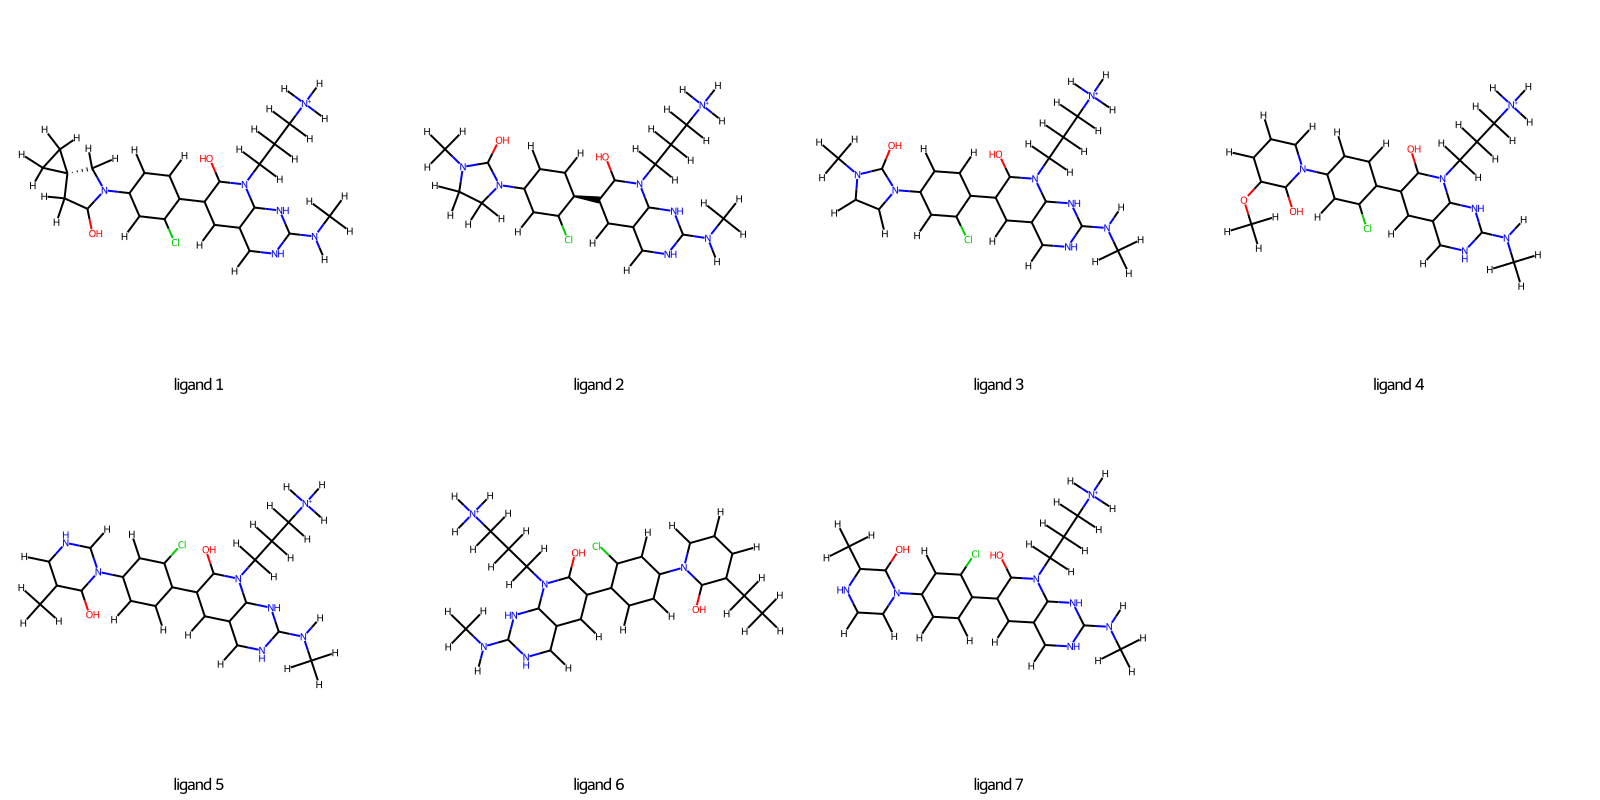

In [6]:
# draw molecules
for mol in mols: AllChem.Compute2DCoords(mol)
Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(400,400),legends=['ligand ' + str(i) for i in range(1, len(mols)+1)])  

In [7]:
# Do a maximum common substructure search 

mcs = rdFMCS.FindMCS(mols, 
                     atomCompare=rdFMCS.AtomCompare.CompareAny, 
                     bondCompare=rdFMCS.BondCompare.CompareAny, 
                     threshold=0.5) #completeRingsOnly=True, ringMatchesRingOnly=True)

In [8]:
smarts = mcs.smartsString
print (smarts)

[#6,#7](-[#6](-[#1,#6])(-[#1])-[#1])(-[#6](-[#7,#1,#6])-[#1])-[#6](-[#7](-[#6]-[#1,#8])-[#6]1-[#6](-[#6](-[#6](-[#6](-[#6]-1-[#1])-[#17,#1])-[#6]1-[#6](-[#6]2-[#6](-[#7]-[#6](-[#7]-[#6]-2-[#7](-[#6]-1-[#8])-[#6](-[#6](-[#6](-[#7](-[#1])(-[#1])-[#1])(-[#1])-[#1])(-[#1])-[#1])(-[#1])-[#1])-[#7](-[#6](-[#1])(-[#1])-[#1])-[#1])-[#1])-[#1])-[#1,#17])-[#1])-[#8,#1]


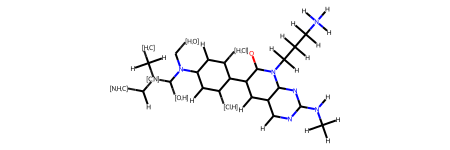

In [9]:
substruct = Chem.MolFromSmarts(smarts)
substruct

In [130]:
# Important: this is the manually curated smarts string because MCS took too long to run

In [11]:
smarts_manual = '[#1,#6,#7]-[#6]1-[#6](-[#6](-[#6]' 
smarts_manual+= '(-[#6](-[#6]-1-[#1])-[#1])'
smarts_manual+= '-[#6]1-[#6](-[#6]2-[#6]'
smarts_manual+= '(-[#7]-[#6](-[#7]-[#6]-2-[#7](-[#6]-1-[#8])-[#6](-[#6](-[#6](-[#7](-[#1])(-[#1])-[#1])(-[#1])-[#1])(-[#1])-[#1])(-[#1])-[#1])-[#7](-[#6](-[#1])(-[#1])-[#1])-[#1])-[#1])-[#1])-[#17])-[#1]'

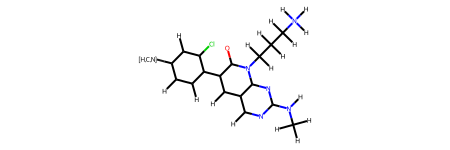

In [12]:
# draw the new substrure for clarity
substruct = Chem.MolFromSmarts(smarts_manual)

substruct


In [13]:
# determine the mapping of the core atoms based on the substructure match

substruct = Chem.MolFromSmarts(smarts_manual)

core_mappings = [] # list of mappings to substructures

for mol in mols:
    core_mapping = [i+1 for i in mol.GetSubstructMatch(substruct)]
    core_mappings.append(core_mapping)
    
    #print (core_mapping)
    #print ('\n') 

In [21]:
core_mappings[0]

[3,
 10,
 11,
 12,
 13,
 14,
 15,
 43,
 42,
 16,
 17,
 18,
 22,
 23,
 24,
 25,
 19,
 20,
 21,
 32,
 28,
 29,
 30,
 31,
 56,
 57,
 58,
 54,
 55,
 52,
 53,
 50,
 51,
 26,
 27,
 47,
 48,
 49,
 46,
 45,
 44,
 1,
 41]

In [20]:
core_mappings[2][0]

25

In [246]:
# Now that the mapping has been established, write the perturbed topology

# ligand 1 core region is 
# [1:] is because i couldn't remove that one extra atom in the smarts string, but it shouldn't be there 

lig1_core = core_mappings[0][1:]
hybrid_top = Top(reduced_tops_path+'/PAK_openff_hybrid.top')
out_path = reduced_tops_path+'/PAK_openff_hybrid_v2.ptp'

constructPerturbedTopology_v2(hybrid_top, tops, lig1_core, core_mappings, out_path)

working on this


In [242]:
def findIndexInSingleTop(hybrid_id, core_mappings, initial_lig_num):
    """
    This function will find the index that a hybrid atom had in its initial topology 
    
    """
    #print ('looking for hybrid atom ' + str(hybrid_id)+ '\'s original id in ligand ' + str(initial_lig_num)+' topology')
    
    # 1: Find index in core of ligand 1
    idx = core_mappings[0].index(hybrid_id)
     
    # 2: return the ID of the other ligand
    return core_mappings[initial_lig_num-1][idx]


In [247]:
def constructPerturbedTopology_v2(hybrid_topology, single_topologies, lig1_core, core_mappings, out_path, alphalj = 1.0, alphacrf = 1.0):
    """
        This function will create the perturbed topology for our hybrid topology. 
        All ligands atoms will be written down (so energies in the EDS blocks of the output match what we want).
        
        Shared core atoms will have the same atom type code in all states. 
        -R groups will be dummy in all other states. 
    
        note: The core isn't sorted so there are ligand 1 -R group atoms in the middle of the ptp.
        
        v2: now also changes the parameters of the core region 
        
        Parameters
        ----------
            hybrid_topology: pyGromos Top 
                regular topology from which we will create the hybrid topology
            lig1_core: List [int]
                list of atoms which make up the core (present for all perturbed states)
            core_mappings: List [List[int]]
                list of atoms in the substructured. The inner lists follow the same order
                so the second element in each sublist corresponds to the same hybrid atom
                
            
            out_path: str
                path to save the output ptp in
                
            alphalj: float
                alpha parameter for the LJ interaction
            alphacrf: float
                    alpha parameter for the CRF interaction
    
    """    
    # count number of residues
    num_atoms = hybrid_topology.SOLUTEATOM.content[-1].ATNM
    num_states = hybrid_topology.SOLUTEATOM.content[-1].MRES

    dummy_iac = hybrid_topology.ATOMTYPENAME.content[0][0] # assumes dummy iac is always last

    # open the output file.
    f = open(out_path, 'w')

    # Write title block.

    date_time = datetime.now().strftime("%d/%m/%Y %H:%M")
    f.write('TITLE\n\tFile created automatically from ' + hybrid_topology.path +'\n')
    f.write('\tby ' + os.environ['USER'] + ' on ' + date_time + '\nEND\n')

    # Write the MPERTATOM block

    f.write('MPERTATOM\n# NJLA:   number of perturbed atoms\n')
    f.write('# NPTB:   number of listed perturbation (i.e. number of perturbation states)\n')
    f.write('# NJLA    NPTB\n')

    # Write the values to NJLA and NPTB:
    f.write('\t' + str(num_atoms) + '\t\t' + str(num_states) + '\n')

    # Write state identifiers
    identifiers = ""
    for i in range(num_states) : identifiers += "ligand"+str(i+1) + "\t"

    f.write('# identifiers of the states\n\t' + identifiers +'\n')

    # comment to understand the content
    f.write('#  NR  NAME IAC(1) CHARGE(1) ...  IAC(n) CHARGE(n)  ALPHLJ  ALPHCRF\n')

    # Loop over topology atoms to include in the ptp

    for atom in hybrid_topology.SOLUTEATOM.content:

        ptp_str = '\t' + str(atom.ATNM) + '\t' + str(atom.PANM) +'\t'

        # charge offset to make formating look good
        q_offset = ' ' if atom.CG > 0 else ''

        if atom.MRES == 1 and atom.ATNM in lig1_core:
            for i in range(num_states): 
                if i == 0:
                    ptp_str += str(atom.IAC) + '\t' + q_offset + "{:.5f}".format(atom.CG) + '\t'
                else: # write parameters of the core from other topologies
                    
                    # Find the mapping for that atom:
                    idx_singletop = findIndexInSingleTop(atom.ATNM, core_mappings, i+1)
                    tmp_iac = single_topologies[i].SOLUTEATOM.content[idx_singletop-1].IAC
                    tmp_q = single_topologies[i].SOLUTEATOM.content[idx_singletop-1].CG
                    
                    q_offset = ' ' if tmp_q > 0 else ''
                    
                    ptp_str += str(tmp_iac) + '\t' + q_offset + "{:.5f}".format(tmp_q) + '\t'
                    
                    
                
                
        else: # Dealing with -R groups (params already good in the perturbed top)
            for i in range(num_states):
                if i == atom.MRES-1:
                    ptp_str += str(atom.IAC) + '\t' + q_offset + "{:.5f}".format(atom.CG) + '\t'
                else:
                    ptp_str += str(dummy_iac) + '\t ' + "{:.5f}".format(0) + '\t'

        # Always prepend alpha LJ and alpha CRF values

        ptp_str += "{:.5f}".format(alphalj) + '\t' + "{:.5f}".format(alphacrf) + '\n'
        f.write(ptp_str)

    # close the block
    f.write('END\n')
    f.close()

    return None
